****How long does it take for a loan to be fully funded?****

In this notebook, we explore how long it takes for a loan to be fully funded on Kiva. We use supervised machine learning techniques to create a model that predicts this time. By analyzing important factors such as loan amount, sector, repayment interval, and others, we aim to make accurate predictions about how long the loan disbursement process might take.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor
import shap
import joblib

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Loading and Cleaning the data**

In [4]:
# Load data
import requests
from zipfile import ZipFile
from io import BytesIO

## load the big loan data
loan_data_path = [f"https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_{i}.csv.zip" for i in range(3)]
rs = [requests.get(path) for path in loan_data_path]
files = [ZipFile(BytesIO(r.content)) for r in rs]
loan_data = []
i = 0 
for f in files:
    loan_data.append(pd.read_csv(f.open(f"kiva_loans_part_{i}.csv")))
    i += 1

## concat all parts of kiva_loan_data
df = pd.concat(loan_data)

# Load mpi data 
mpi=pd.read_csv('mpi_by_country.csv')
mpi.rename(columns={'Country': 'country'}, inplace=True)
df_merged = df.merge(mpi[['country', 'MPI']], on='country', how='left')
df_merged = df_merged.dropna(subset=['MPI'])

# calculate time for a loan to be fully funded
date_cols = ['disbursed_time', 'funded_time']
for col in date_cols:
    df_merged[col] = pd.to_datetime(df_merged[col])
df_merged['days_fully_funded'] = np.ceil((df_merged['funded_time'] - df_merged['disbursed_time']) / np.timedelta64(1, 'D'))

## remove column with days to fully funded < 0
df_merged = df_merged[df_merged['days_fully_funded'] > 0]

## remove outliers
Q1 = np.percentile(df['loan_amount'], 25, method='midpoint')
Q3 = np.percentile(df['loan_amount'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
df_merged = df_merged[(df_merged['loan_amount'] < upper) & (df_merged['loan_amount'] > lower)]

# Display initial information about the dataset
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529115 entries, 0 to 671201
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   id                  529115 non-null  int64              
 1   funded_amount       529115 non-null  float64            
 2   loan_amount         529115 non-null  float64            
 3   activity            529115 non-null  object             
 4   sector              529115 non-null  object             
 5   use                 526590 non-null  object             
 6   country_code        529115 non-null  object             
 7   country             529115 non-null  object             
 8   region              501444 non-null  object             
 9   currency            529115 non-null  object             
 10  partner_id          529014 non-null  float64            
 11  posted_time         529115 non-null  object             
 12  disbursed_time      5

In [5]:
# cleaning borrower_genders column because of inconsistent values like "female,female"
def replace_gender_values(value):
    if isinstance(value, str):  
        if 'f' in value.lower():
            return 'female'
        else:
            return 'male'
    return value  

# Apply the function to clean the borrower_genders column
df_merged['borrower_genders'] = df_merged['borrower_genders'].apply(replace_gender_values)


In [6]:
# Select features
selected_features=['loan_amount','sector','term_in_months','lender_count','repayment_interval','borrower_genders','MPI','days_fully_funded']
df = df_merged[selected_features]

# Display information about selected features
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529115 entries, 0 to 671201
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loan_amount         529115 non-null  float64
 1   sector              529115 non-null  object 
 2   term_in_months      529115 non-null  float64
 3   lender_count        529115 non-null  int64  
 4   repayment_interval  529115 non-null  object 
 5   borrower_genders    526594 non-null  object 
 6   MPI                 529115 non-null  float64
 7   days_fully_funded   529115 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 36.3+ MB


In [7]:
df.head(5)

,loan_amount,sector,term_in_months,lender_count,repayment_interval,borrower_genders,MPI,days_fully_funded
0,300.0,Food,12.0,12,irregular,female,0.230,17.0
1,575.0,Transportation,11.0,14,irregular,female,0.230,17.0
2,150.0,Transportation,43.0,6,bullet,female,0.191,16.0
3,200.0,Arts,11.0,8,irregular,female,0.230,9.0
4,400.0,Food,14.0,16,monthly,female,0.230,16.0


**Our target virable**:

Days_fully_funded

**Explanation of Feature Selection**

Loan Amount: Larger loans tend to take more time to fund because they need more money from multiple lenders.

Sector: Some sectors, like agriculture or retail, may attract more or less interest, which affects how quickly the loan is funded.

Term in Months: Loans with shorter repayment periods are often funded faster, while longer-term loans might take more time.

Lender Count: The more lenders involved, the quicker the loan is usually funded, as it shows higher interest.

MPI: Borrowers from poorer countries may face slower funding since lenders may see these loans as riskier.

Payment Interval: Loans with more frequent repayments might be funded quicker because they seem safer to lenders.

Borrower Gender: Gender can affect funding speed, with some programs focused on supporting women, leading to faster funding for these loans.








**Handling missing data**

In [8]:
# I will use knn imputation to fill missing values but KNN works on numerical values so first I have to encode categorical virables to numbers 

from sklearn.preprocessing import LabelEncoder

# Label Encoding for borrower_genders
label_encoder = LabelEncoder() 
df['borrower_genders_encoded'] = label_encoder.fit_transform(df['borrower_genders'].astype(str))

# Select relevant features for KNN imputation
knn_data = df[['borrower_genders_encoded']]

# Initialize and apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(knn_data)

# Update the original dataframe with imputed values
df['borrower_genders_encoded'] = knn_imputed[:, 0]

print("Missing values after imputation:")
print(df['borrower_genders_encoded'].isna().sum())

Missing values after imputation:
0


/var/folders/60/6wzpsym51m734jtcp7v8wqn40000gn/T/ipykernel_9971/3357214377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['borrower_genders_encoded'] = label_encoder.fit_transform(df['borrower_genders'].astype(str))
/var/folders/60/6wzpsym51m734jtcp7v8wqn40000gn/T/ipykernel_9971/3357214377.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['borrower_genders_encoded'] = knn_imputed[:, 0]


**Feature Engenering**

In [9]:
# Separate features and target
X = df.drop('days_fully_funded', axis=1)
y = df['days_fully_funded']

# One-hot encoder for categorical virables repayment_interval and sector
ohe = OneHotEncoder() 
cat_features = ['sector', 'repayment_interval']
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# we are adding also borrower_genders which was encoded in previous cell
X_cat['borrower_genders_encoded'] = df['borrower_genders_encoded']

# Scale numerical features
scaler = StandardScaler()
num_features = ['loan_amount','term_in_months', 'lender_count', 'MPI']
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([X_num, X_cat], axis=1)

print("Shape of processed features:", X_processed.shape)


Shape of processed features: (529115, 24)


We used standarscaler for all numerical features. Now all the numerical features will have mean 0 and unit variance which is important for ml algorthms, it will be easier to work with data

In [10]:
X_processed.head(5)

,loan_amount,term_in_months,lender_count,MPI,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,...,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,borrower_genders_encoded
0,-0.601234,-0.147088,-0.289498,0.970896,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.061279,-0.279996,-0.138386,0.970896,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.962605,3.973080,-0.742835,0.626246,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.842148,-0.279996,-0.591723,0.970896,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.360320,0.118730,0.012726,0.970896,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Model Training and Evaluation**

We will use Random Forest and XGBooster and for evaluation RMSE. RMSE measure how far the model's predictions are from actual values. 

In [11]:
from sklearn.model_selection import train_test_split

# Split the data, X is our features and y is our target virable (days_fully_funded)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 11.96
Test RMSE: 12.14


In [12]:
## Train RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))

print(f"Random Forest Regressor Train RMSE: {train_rmse:.2f}")
print(f"Random Forest Regressor Test RMSE: {test_rmse:.2f}")

Random Forest Regressor Train RMSE: 8.42
Random Forest Regressor Test RMSE: 12.67


Random Forest Regresor performed better on training set but had worst score on test set. XGBoost demonstrates greater consistency. For XGBoost there is small difference between Train RMSE and Test RMSE split suggests that the model generalizes well to new data and is not overfitting.

**GridSearchCV**

In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the XGBoost model
model = XGBRegressor(random_state=42)

# Simplified hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],       
    'learning_rate': [0.05, 0.1],     
    'max_depth': [3, 5]               
}

# Initialize GridSearchCV with standard K-Fold cross-validation 
grid_search = GridSearchCV(
    estimator=model,              
    param_grid=param_grid,         
    cv=5,                         
    scoring='neg_mean_squared_error',  # Negative MSE to minimize error
    n_jobs=-1,                    
    verbose=1                     
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Calculate and display RMSE from the best result
best_neg_mse = grid_search.best_score_  
best_rmse = (-best_neg_mse) ** 0.5      

print("Best RMSE:", best_rmse)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best RMSE: 12.330111922534195


In [15]:
# Now, manually initializing XGBRegressor with specific optimized hyperparameters
xgbr_optimized = XGBRegressor(learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=200)

# Fit the optimized model to the training data
xgbr_optimized.fit(X_train, y_train)

# Evaluate the model on the training data
train_rmse = np.sqrt(mean_squared_error(y_train, xgbr_optimized.predict(X_train)))

# Evaluate the model on the test data
test_rmse = np.sqrt(mean_squared_error(y_test, xgbr_optimized.predict(X_test)))

# Print the RMSE for both training and test sets
print(f"XGBRegressor Train RMSE: {train_rmse:.2f}")
print(f"XGBRegressor Test RMSE: {test_rmse:.2f}")

XGBRegressor Train RMSE: 11.74
XGBRegressor Test RMSE: 12.04


The new results show a slight improvement in model accuracy, indicating that the model fits the data better and generalizes well on the test set.

**Explainability**

SHAP model shows how much each feture contibutes to the predictions model

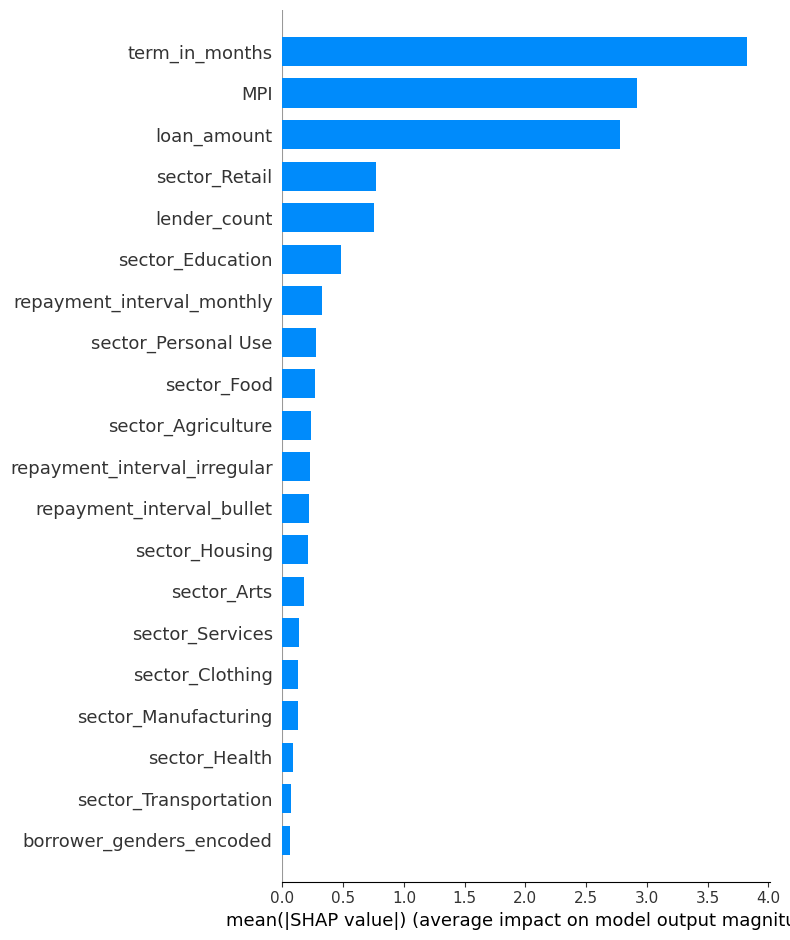

In [18]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")



From the plot we can see thar term in months, mpi and loan amount are 3 top features that contributed the most in our model 

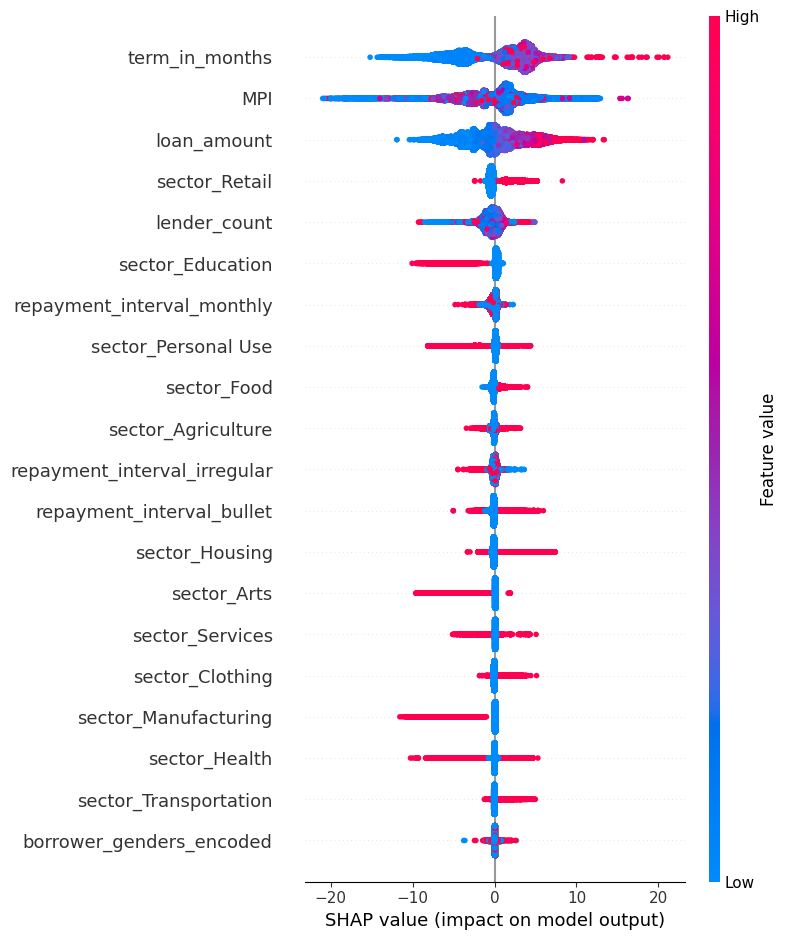

In [19]:
# Plot SHAP values
shap.summary_plot(shap_values, X_test)

The SHAP plot shows that the most significant feature is term_in_months, where longer loan terms (red points) increase the funding time, and shorter terms (blue points) decrease it.

When we look at the MPI feature, we can see that countries with a lower MPI have shorter funding times. This could be because people are often more hesitant to lend money to poorer regions.

As for the loan_amount, higher loan amounts are associated with longer funding times.

**Saving the model**

In [20]:
joblib.dump(model_xgb, 'model_xgb.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']